In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy import units as u

from astropy.nddata import CCDData, StdDevUncertainty


from astropy import wcs
from astropy.io import fits
import sys

%matplotlib inline


In [2]:
#Name of lambda calibrated 2D spectra image
sci = 'gCas-extr.fits'


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


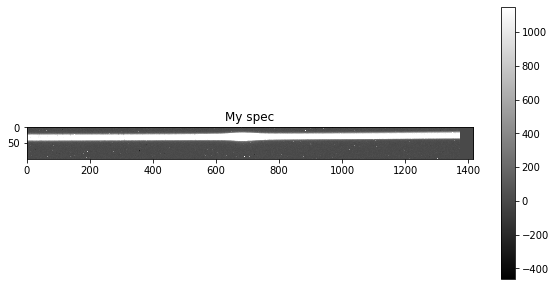

In [3]:
#Display image spectrum 

sciimg = CCDData.read(sci, unit=u.adu)

def imshow(im, title_name='My spec'):
    # - - Shows 2D image with some additional info              - - #
    # - - Parameters: im -> ndarray; 2D image stored as ndarray - - #
    # - - Returns:    nothing                                   - - #

    plt.figure(figsize = (10, 5))
    plt.imshow(im, vmax = np.mean(im) + np.std(im), vmin = np.mean(im) - np.std(im), cmap = 'gray')
    plt.title(title_name)
    plt.colorbar()
    
imshow(sciimg)

### SPECTRUM PROFILE ALONG Y - use it only to check/validate data integrity and to decide whether to cut some rows from the original spectrum

In [4]:
hdulist = fits.open(sci)


w = wcs.WCS(hdulist[1].header)


y_pixels,x_pixels = hdulist[1].data.shape

print(y_pixels,x_pixels)

#Create inital image matrix of all possible locations
pixcrd = np.array([[y , x] for y in range(y_pixels) for x in range(x_pixels)], dtype=np.float64)


# Convert pixel coordinates to world coordinates
# The second argument is "origin" -- in this case we're declaring we
# have 0-based (Numpy-like) coordinates.
# We convert all possible locations
world = w.wcs_pix2world(pixcrd, 0)


min_lambda = world[:,0].min()
max_lambda =world[:,0].max()

print('Lambda range is between ', min_lambda, ' and ', max_lambda)

#Decide on lambda increments to sum columns values
delta_lambda = (max_lambda - min_lambda )/ x_pixels

#Filter world coords to certain lambda range
lambda_map_to_pixel_group = {}
while min_lambda < max_lambda:
    pixels_at_lambda = np.where(np.logical_or(np.logical_and(world>=min_lambda, world< min_lambda+ delta_lambda),world> 0.01 ),  world, np.nan)
    lambda_map_to_pixel_group[min_lambda] = pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])]
    #print(pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])])
    
    min_lambda += delta_lambda
    
# Now go back to pixel coords and sum columns

signal_array = []
for wavelength in lambda_map_to_pixel_group.keys():
    if lambda_map_to_pixel_group[wavelength].shape[0] > 0:
        #print(wl, lambda_map_to_pixel_group[wl].shape)
        pixcrd2 = w.wcs_world2pix(lambda_map_to_pixel_group[wavelength], 0)
        #print(pixcrd2)
        signal = 0
        pixel_values_in_list = []
        for pixel in pixcrd2:
            pixel_value = hdulist[1].data[int(pixel[0])][int(pixel[1])]###change to change direction
            pixel_values_in_list.append(pixel_value)
            signal += pixel_value
        signal_array.append([wavelength, signal,pixel_values_in_list, len(pixel_values_in_list)] )


        
spectrum = pd.DataFrame(signal_array)

spectrum.rename({0:'Lambda', 1:'Signal', 2:'Actual Pixel Values',3:'Count Pixels' }, axis = 1, inplace=True)
spectrum.reset_index(inplace=True)
display(spectrum)


100 1417
Lambda range is between  6.48e-07  and  6.49188e-07


,index,Lambda,Signal,Actual Pixel Values,Count Pixels
0,0,6.480000e-07,19518.281052,"[8.270410462173595, 4.759416269328918, 33.2529...",1417
1,1,6.480117e-07,19939.918797,"[-0.537064376957548, 11.27850439833585, 25.656...",1417
2,2,6.480235e-07,21903.996433,"[8.822836796181656, 11.729617216886448, 26.882...",1417
3,3,6.480352e-07,22989.469204,"[17.691535999076653, 10.012648012504055, 26.04...",1417
4,4,6.480478e-07,22989.469204,"[17.691535999076653, 10.012648012504055, 26.04...",1417
...,...,...,...,...,...
95,95,6.491394e-07,15974.031567,"[-3.9528095744870018, 23.742955148495057, 12.8...",1417
96,96,6.491519e-07,16755.739269,"[2.6543657223593864, 9.464139403481852, 15.291...",1417
97,97,6.491637e-07,15285.121619,"[14.686530619360948, -4.342472546487864, 23.72...",1417
98,98,6.491754e-07,15285.121619,"[14.686530619360948, -4.342472546487864, 23.72...",1417


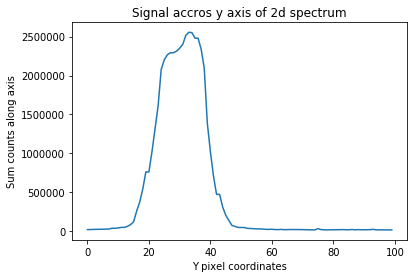

In [5]:
plt.plot(spectrum['index'], spectrum['Signal'])
plt.title('Signal accros y axis of 2d spectrum')
plt.xlabel('Y pixel coordinates')
plt.ylabel('Sum counts along axis')


plt.show()


### 1-D Wavelength Spectrum - same as above but read accros a different dimension to get counts vs lambda with the option to filter some rows (next cell)

In [6]:
###From the images - decide if you want to cut on y direction
read_y_min, read_y_max = 0, y_pixels
#read_y_min = 20
#read_y_max = 40

100 1417
6.48e-07 6.64992e-07


,Lambda,Signal,Actual Pixel Values,Count Pixels
0,6.480000e-07,28490.566856,"[8.270410462173595, -0.537064376957548, 8.8228...",100
1,6.480120e-07,28318.191170,"[4.759416269328918, 11.27850439833585, 11.7296...",100
2,6.480240e-07,28134.626782,"[33.25291110450148, 25.656516040964238, 26.882...",100
3,6.480360e-07,27973.727087,"[19.44612945602106, 10.028585743422857, 25.154...",100
4,6.480480e-07,27973.727087,"[19.44612945602106, 10.028585743422857, 25.154...",100
...,...,...,...,...
1412,6.649320e-07,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100
1413,6.649440e-07,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100
1414,6.649560e-07,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100
1415,6.649680e-07,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",100


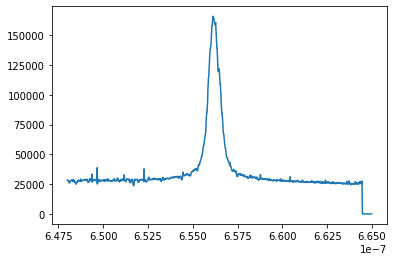

In [7]:
hdulist = fits.open(sci)


w = wcs.WCS(hdulist[1].header)


y_pixels,x_pixels = hdulist[1].data.shape

print(y_pixels,x_pixels)
pixcrd = np.array([[x , y] for y in range(y_pixels) for x in range(x_pixels)], dtype=np.float64)

# Convert pixel coordinates to world coordinates
# The second argument is "origin" -- in this case we're declaring we
# have 0-based (Numpy-like) coordinates.

world = w.wcs_pix2world(pixcrd, 0)
#print(world)
min_lambda = world[:,0].min()
max_lambda = world[:,0].max()
print(min_lambda,max_lambda)

delta_lambda = (max_lambda - min_lambda )/ x_pixels

lambda_map_to_pixel_group = {}
while min_lambda < max_lambda:
    pixels_at_lambda = np.where(np.logical_or(np.logical_and(world>=min_lambda, world< min_lambda+ delta_lambda),world> 0.01 ),  world, np.nan)
    lambda_map_to_pixel_group[min_lambda] = pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])]
    #print(pixels_at_lambda[~np.isnan(pixels_at_lambda[:,0])])
    
    min_lambda += delta_lambda
    
signal_array = []
for wl in lambda_map_to_pixel_group.keys():
    #print(wl, lambda_map_to_pixel_group[wl].shape)
    pixcrd2 = w.wcs_world2pix(lambda_map_to_pixel_group[wl], 0)
    #print(pixcrd2)
    signal = 0
    pixel_values_in_list = []
    for pixel in pixcrd2:
        if pixel[1] >= read_y_min and pixel[1] <read_y_max:
            pixel_value = hdulist[1].data[int(pixel[1])][int(pixel[0])]
            pixel_values_in_list.append(pixel_value)
            signal += pixel_value
    signal_array.append([wl, signal,pixel_values_in_list, len(pixel_values_in_list)] )


spectrum = pd.DataFrame(signal_array)

spectrum.rename({0:'Lambda', 1:'Signal', 2:'Actual Pixel Values',3:'Count Pixels' }, axis = 1, inplace=True)
display(spectrum)
plt.plot(spectrum['Lambda'], spectrum['Signal'])
plt.show()

## Save 1-D Spectrum file

In [8]:
spectrum[['Lambda', 'Signal','Count Pixels']].to_csv('{}-1d-spec.csv'.format(sci.replace('.fits','')), index=False)